## Run Network
Script for using existing network to run on cohort data

In [6]:
import os
import numpy as np
from deepcell.model_zoo import bn_feature_net_2D, bn_feature_net_2D
import matplotlib.pyplot as plt
import xarray as xr
import math

In [10]:
# load data
data_dir = '/data/felix/20191001_cohort/'
cohort_xr = xr.load_dataarray(data_dir + 'Deepcell_Input.nc')

In [9]:
# load model
experiment_folder = "20190822_training_freeze_1"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
#MODEL_NAME = 'Training_Freeze_1_Nuc_HH3_81_rf_512_dense_128_conv_epoch_18.h5'
MODEL_NAME = 'Training_Freeze_1_Nuc_81_rf_512_dense_128_conv_epoch_24.h5'
weights_path = os.path.join(MODEL_DIR, MODEL_NAME)

In [11]:
run_sample_model = bn_feature_net_2D(
    n_dense_filters=512,
    n_conv_filters=128,
    dilated=True,
    n_features=3,
    norm_method='std',
    receptive_field=81,
    n_channels=1,    
    input_shape=cohort_xr.shape[1:])

run_sample_model.load_weights(weights_path)

In [15]:
output_array = np.zeros((cohort_xr.shape[:3] + (3,)))

In [17]:
# run through supplied points
batch_size = 2
size = cohort_xr.shape[0]
num_batch = math.floor(size / batch_size)    

In [18]:
for i in range(num_batch):
    print("start at {}".format(i * batch_size))
    print("end at {}".format((i + 1)*batch_size))
    output_array[(i * batch_size):((i + 1)*batch_size), :, :, :] = run_sample_model.predict(cohort_xr.values[(i * batch_size):((i + 1)*batch_size), :, :, :])
if size % batch_size != 0:
    print("start at {}".format(num_batch * batch_size))
    print("end at {}".format(num_batch * batch_size + size % batch_size))
    output_array[(num_batch * batch_size):(num_batch * batch_size + size % batch_size), :, :, :] = run_sample_model.predict(cohort_xr_new.values[(num_batch * batch_size):(num_batch * batch_size + size % batch_size), :, :, :])

start at 0
end at 2
start at 2
end at 4
start at 4
end at 6
start at 6
end at 8
start at 8
end at 10
start at 10
end at 12
start at 12
end at 14
start at 14
end at 16
start at 16
end at 18
start at 18
end at 20
start at 20
end at 22
start at 22
end at 24
start at 24
end at 26
start at 26
end at 28
start at 28
end at 30
start at 30
end at 32
start at 32
end at 34
start at 34
end at 36
start at 36
end at 38
start at 38
end at 40
start at 40
end at 42
start at 42
end at 44
start at 44
end at 46
start at 46
end at 48
start at 48
end at 50
start at 50
end at 52
start at 52
end at 54
start at 54
end at 56
start at 56
end at 58


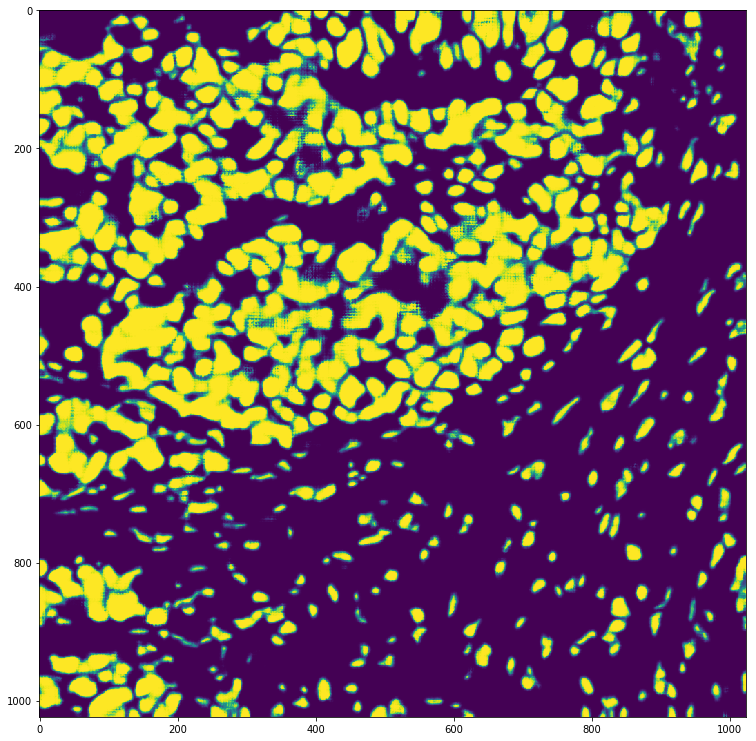

In [29]:
plt.figure(figsize = (13, 13))
plt.imshow(output_array[24, :, :, 1])

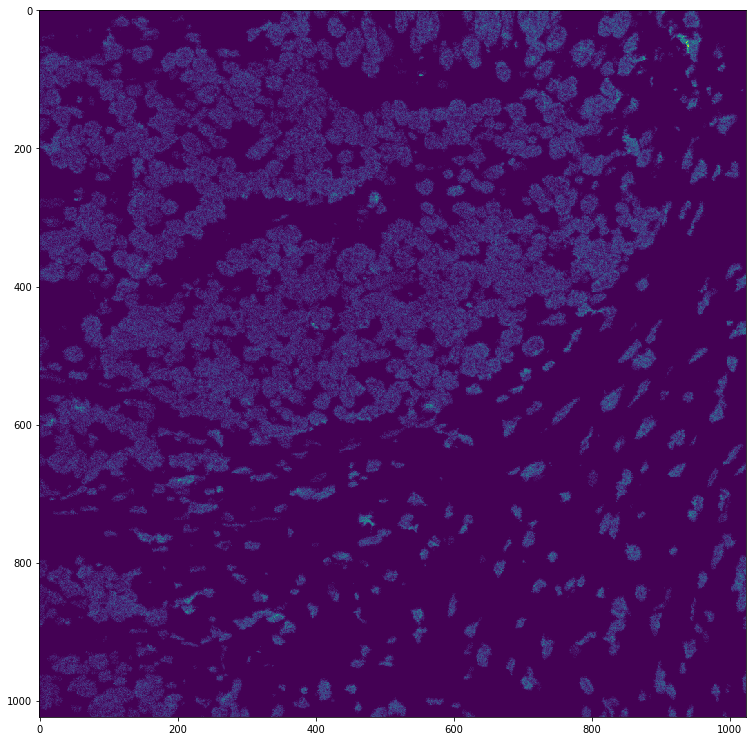

In [33]:
plt.figure(figsize = (13, 13))
plt.imshow(cohort_xr.values[24, :, :, 1])

In [36]:
xr_output = xr.DataArray(output_array,
                         coords=[cohort_xr.coords['points'], range(1024), range(1024), ['border', 'interior', 'bg']],
                         dims=['points', 'rows', 'cols', 'masks'])
xr_output.to_netcdf(os.path.join(data_dir, "deepcell_output.nc"), format="NETCDF3_64BIT")

In [37]:
cohort_xr.name

'TMA1_run1_no_noise'

# Run watershed network

In [13]:
experiment_folder = "20190914_tuning"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
MODEL_NAME = 'Training_Freeze_1_Nuc_watershed_81_rf_256_dense_64_conv_2erosion_epoch_03.h5'
watershed_weights_path = os.path.join(MODEL_DIR, MODEL_NAME)

In [14]:
run_watershed_model = bn_feature_net_2D(
    dilated=True,
    receptive_field=81,
    n_features=4,
    input_shape=tuple(cohort_xr.shape[1:]), 
    n_conv_filters=64,
    n_dense_filters=256)
run_watershed_model.load_weights(watershed_weights_path)

In [15]:
output_array_watershed = np.zeros((cohort_xr.shape[:3] + (4,)))

In [18]:
for i in range(num_batch):
    print("start at {}".format(i * batch_size))
    print("end at {}".format((i + 1)*batch_size))
    output_array_watershed[(i * batch_size):((i + 1)*batch_size), :, :, :] = run_watershed_model.predict(cohort_xr.values[(i * batch_size):((i + 1)*batch_size), :, :, :])
if size % batch_size != 0:
    print("start at {}".format(num_batch * batch_size))
    print("end at {}".format(num_batch * batch_size + size % batch_size))
    output_array_watershed[(num_batch * batch_size):(num_batch * batch_size + size % batch_size), :, :, :] = run_watershed_model.predict(cohort_xr_new.values[(num_batch * batch_size):(num_batch * batch_size + size % batch_size), :, :, :])

start at 0
end at 2
start at 2
end at 4
start at 4
end at 6
start at 6
end at 8
start at 8
end at 10
start at 10
end at 12
start at 12
end at 14
start at 14
end at 16
start at 16
end at 18
start at 18
end at 20
start at 20
end at 22
start at 22
end at 24
start at 24
end at 26
start at 26
end at 28
start at 28
end at 30
start at 30
end at 32
start at 32
end at 34
start at 34
end at 36
start at 36
end at 38
start at 38
end at 40
start at 40
end at 42
start at 42
end at 44
start at 44
end at 46
start at 46
end at 48
start at 48
end at 50
start at 50
end at 52
start at 52
end at 54
start at 54
end at 56
start at 56
end at 58


In [21]:
argmax_images = []
for j in range(output_array_watershed.shape[0]):
    argmax_images.append(np.argmax(output_array_watershed[j, ...], axis=-1))
argmax_images = np.array(argmax_images)

In [26]:
cohort_xr.points[20]

<xarray.DataArray 'points' ()>
array('Point18', dtype='<U7')
Coordinates:
    points   <U7 'Point18'

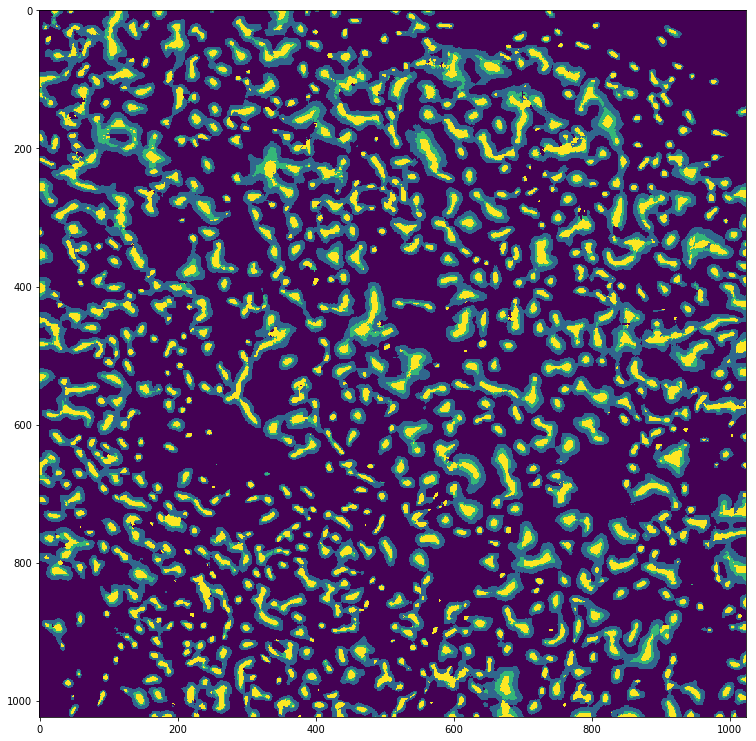

In [25]:
plt.figure(figsize = (13, 13))
plt.imshow(argmax_images[20, :, :])

In [28]:
xr_output_watershed = xr.DataArray(output_array_watershed,
                         coords=[cohort_xr.coords['points'], range(1024), range(1024), ['level_0', 'level_1', 'level_2', 'level_3']],
                         dims=['points', 'rows', 'cols', 'masks'])
xr_output_watershed.to_netcdf(os.path.join(data_dir, "watershed_output.nc"), format="NETCDF3_64BIT")